In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Split training set into train + validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)


print("Training samples:", x_train.shape[0])
print("Validation samples:", x_val.shape[0])
print("Test samples:", x_test.shape[0])

Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

custom_model = create_custom_cnn()
custom_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_transfer_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False  # Freeze base

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Resize CIFAR-10 to match MobileNetV2 input size
x_train_tf = tf.image.resize(x_train, [96, 96])
x_val_tf = tf.image.resize(x_val, [96, 96])
x_test_tf = tf.image.resize(x_test, [96, 96])

transfer_model = create_transfer_model()
transfer_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [19]:
# Training configuration
EPOCHS = 10
BATCH_SIZE = 64

# Train custom CNN
history_custom = custom_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Train Transfer Learning model
history_transfer = transfer_model.fit(
    x_train_tf, y_train,
    validation_data=(x_val_tf, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.2918 - loss: 1.9211 - val_accuracy: 0.4912 - val_loss: 1.4135
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.4751 - loss: 1.4528 - val_accuracy: 0.5507 - val_loss: 1.2439
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5364 - loss: 1.3037 - val_accuracy: 0.5891 - val_loss: 1.1508
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5753 - loss: 1.2044 - val_accuracy: 0.6237 - val_loss: 1.0589
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6028 - loss: 1.1272 - val_accuracy: 0.6460 - val_loss: 1.0064
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6282 - loss: 1.0688 - val_accuracy: 0.6518 - val_loss: 0.9955
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6353 - loss: 1.0358 - val_accuracy: 0.6626 - val_loss: 0.9654
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6554 - loss: 0.9740 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.8084 - loss: 0.5533
Test Accuracy: 0.8102999925613403
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step
              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.89      0.89      0.89      1000
        bird       0.80      0.73      0.77      1000
         cat       0.65      0.68      0.66      1000
        deer       0.76      0.78      0.77      1000
         dog       0.76      0.70      0.73      1000
        frog       0.82      0.84      0.83      1000
       horse       0.84      0.83      0.83      1000
        ship       0.88      0.89      0.89      1000
       truck       0.86      0.91      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



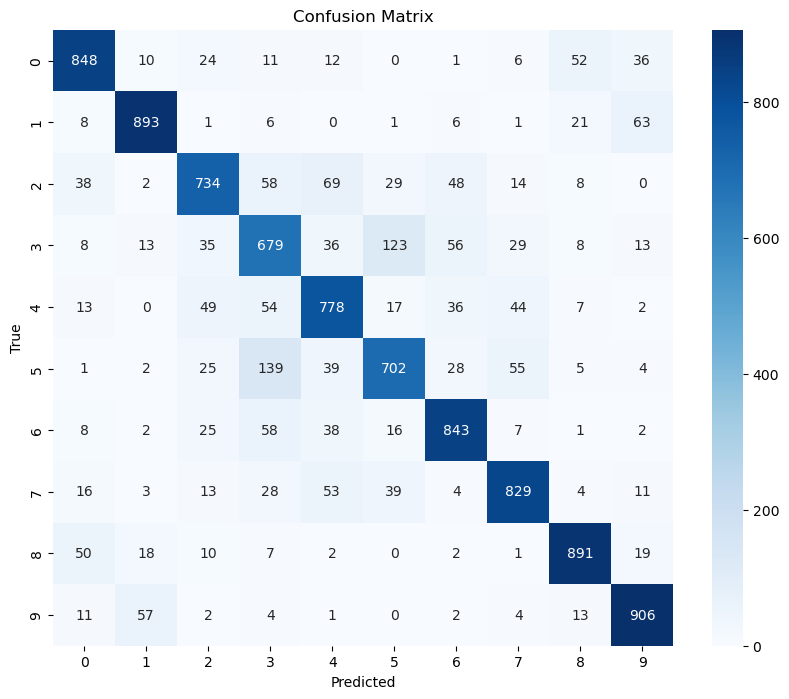

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate test accuracy
test_loss, test_acc = transfer_model.evaluate(x_test_tf, y_test)
print("Test Accuracy:", test_acc)

# Predict and evaluate
y_pred = np.argmax(transfer_model.predict(x_test_tf), axis=1)

# Classification report
print(classification_report(y_test, y_pred, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted: 6
Actual: 6


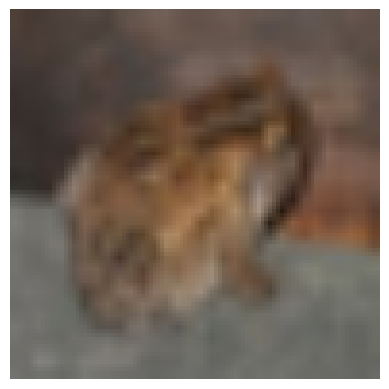

In [23]:
# Run live prediction demo (for slide video)
import random

i = random.randint(0, x_test_tf.shape[0] - 1)
img = x_test_tf[i]
plt.imshow(img.numpy().astype("float32"))
plt.axis('off')
pred = transfer_model.predict(tf.expand_dims(img, axis=0))
print("Predicted:", np.argmax(pred))
print("Actual:", y_test[i][0])
